# Mennan Gök 22003074
## CS 464 Homework 2
## Question 1

In this question, we will analyze the MNIST dataset [http://yann.lecun.com/exdb/mnist/] by implementing Principal Component Analysis from scratch.

In [3]:
import numpy as np
import gzip
import matplotlib.pyplot as plt

# Function to flatten pixels into an array
def flatten_pixels(normalized_pixels):
    return normalized_pixels.reshape((-1, 784))

# Function to read pixel data from the dataset
def read_pixels(data_path):
    with gzip.open(data_path) as f:
        pixel_data = np.frombuffer(f.read(), 'B', offset=16).astype('float32')
    normalized_pixels = pixel_data / 255
    flattened_pixels = flatten_pixels(normalized_pixels) 
    return flattened_pixels

# Function to read label data from the dataset
def read_labels(data_path):
    with gzip.open(data_path) as f:
        label_data = np.frombuffer(f.read(), 'B', offset=8)
    return label_data

images = read_pixels("train-images-idx3-ubyte.gz")
labels = read_labels("train-labels-idx1-ubyte.gz")

# Function to calculate the covarience matrix
def find_cov_mat(images):
    mean_image = np.mean(images, axis = 0)
    centered_image = images - mean_image
    cov_mat = np.dot(centered_image.T, centered_image) / centered_image.shape[0]
    return cov_mat

# Function to calculate the eigenvalues and eigenvectors and sort both according to descending eigenvalues order
def find_rank_eig(cov_mat):
    eigenvalues, eigenvectors = np.linalg.eig(cov_mat)
    sort_index = np.argsort(eigenvalues)[::-1]
    return eigenvalues[sort_index], eigenvectors[:, sort_index]

# Main function to apply pca, returns sorted eigenvalues and eigenvectors
def apply_pca(images):
    #Calculate the covarience matrix
    cov_mat = find_cov_mat(images)
    #Calculate and rank the eigenvalues and eigenvectors in a descending order of eigenvalues
    eigenvalues, eigenvectors = find_rank_eig(cov_mat)
    return eigenvalues, eigenvectors

## Question 1.1
- Calculating the proportion of variance explained for the first 10 principal components

In [4]:
def calculate_pve(num_of_PC, eigenvalues):
    return eigenvalues[:num_of_PC] / np.sum(eigenvalues)

eigenvalues, eigenvectors = apply_pca(images) # both sorted
pve = calculate_pve(10, eigenvalues)
print(f" PVE for first 10 PCs: {pve}")
print(f"Total PVE explained with 10 PCs: {np.sum(pve)}")

 PVE for first 10 PCs: [0.09704665 0.07095925 0.0616909  0.0538942  0.04868798 0.04312232
 0.0327193  0.02883896 0.0276203  0.02357001]
Total PVE explained with 10 PCs: 0.48814985156059265


## Question 1.2
* Calculating the number of principal components to explain the 70% of the data

In [5]:
def calculate_min_required_PC(target_percentage, eigenvalues):
    for i in range(len(eigenvalues)):
        if np.sum(calculate_pve(i, eigenvalues)) >= (target_percentage / 100.0):
            return i
required_pc = calculate_min_required_PC(70, eigenvalues)
print(f"Required number of PCs to explain 70% of the varience: {required_pc}")

Required number of PCs to explain 70% of the varience: 26


## Question 1.3
* Visualizing the first 10 principal components

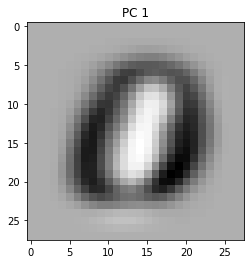

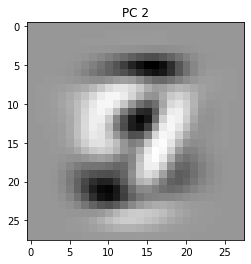

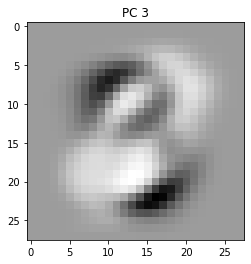

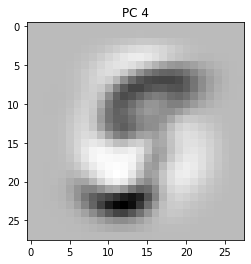

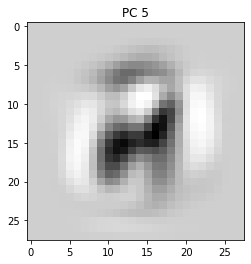

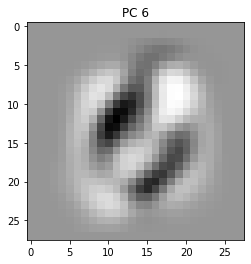

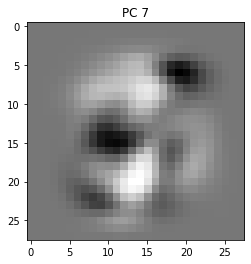

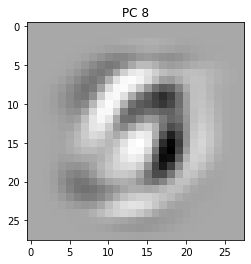

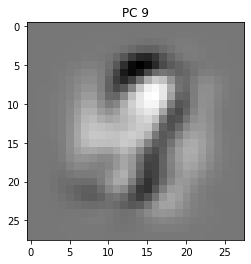

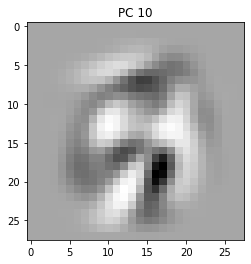

In [6]:
eigenvectors_10 = eigenvectors[:, :10] # first 10 eigenvectors will be visualized
for pc_i in range(10):
    PC = eigenvectors_10[:, pc_i]
    PC = PC.reshape(28, 28)
    plt.imshow(PC, cmap = 'Greys_r')
    plt.title(f"PC {pc_i + 1}")
    plt.show()

## Question 1.4

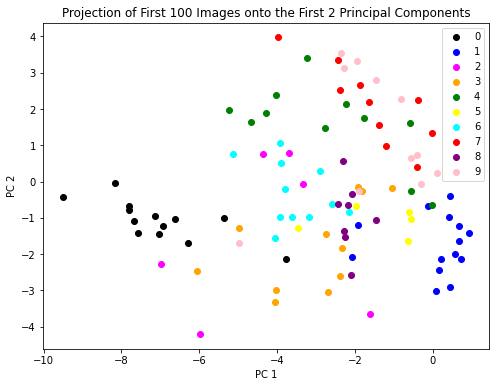

In [7]:
# Function to project `num_of_images` images to `num_of_pc` principal components
def projection(images, eigenvectors, num_of_images = 100, num_of_pc = 2):
    p_matrix = eigenvectors[:, :num_of_pc]
    projected_images= np.dot(images[:num_of_images], p_matrix)
    return projected_images

# Function to plot the projections as a scatter plot
def plot_projection(projection, labels, num_of_images = 100):
    colors = ['black', 'blue', 'magenta', 'orange', 'green', 'yellow', 'cyan', 'red', 'purple', 'pink']    
    plt.figure(figsize = (8, 6))
    for i in range(10): #for each digit
        id_func = (labels[:num_of_images] == i)
        #digit_samples = projection[id_func]
        plt.scatter(projection[id_func, 0],projection[id_func, 1], c = colors[i], label = str(i))
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.title("Projection of First 100 Images onto the First 2 Principal Components")
    plt.legend()
    plt.show()
plot_projection(projection(images, eigenvectors), labels)

## Question 1.5

* To reduce the dimensionality of the data, we first project the original data onto the space spanned by the selected principal components. 

* In the process of reconstruction, we need to project the data in the space of principal components back to the original space. This is achieved by multiplying the reduced data matrix by the transpose of the matrix of the selected components. 

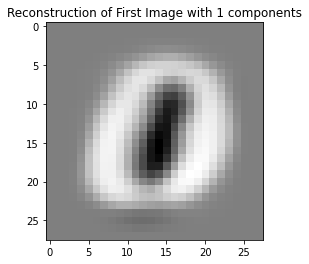

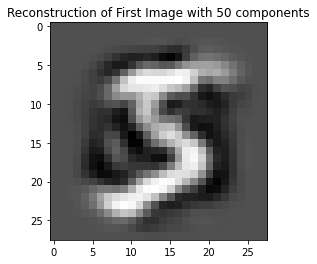

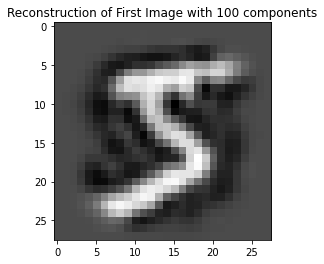

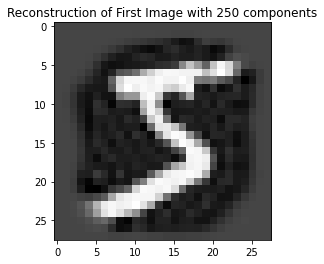

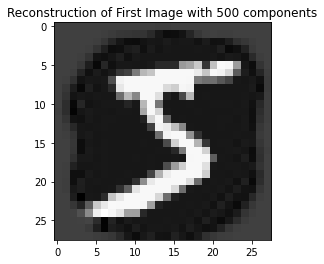

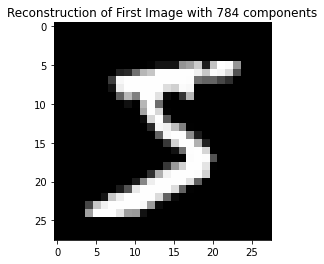

In [8]:
# Function to reconstruct the given image using k principal components
def reconstruct(images, eigenvectors, k): # <- eigenvectors_k, first k eigenvectors
    center_img = images - np.mean(images, axis = 0)
    k_dim_projection = np.dot(center_img, eigenvectors[:, :k]) # <- project onto k dimensions
    projected_img = np.dot(k_dim_projection, eigenvectors[:, :k].T)
    return projected_img + np.mean(images, axis = 0)

k_list = [1, 50, 100, 250, 500, 784]
for k in k_list:
    projected_img = reconstruct(images[0], eigenvectors, k).reshape(28, 28)
    plt.imshow(projected_img, cmap = 'Greys_r')
    plt.title(f"Reconstruction of First Image with {k} components")
    plt.show()
    

# Mennan Gök 22003074
## CS 464 Homework 2
## Question 2

In this question, we will train a Multinomial Logistic Regression Classifier model, implemented from scratch, to classify digits using images taken from MNIST dataset. 

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import gzip
from sklearn import metrics
from tqdm import tqdm

## Methods for reading and pre-processing the data

# One-hot encoding of the labels
def one_hot_encoding(label_data):
    encoded_labels = np.zeros((len(label_data), 10))
    for i, y in enumerate(label_data):
        encoded_labels[i,y] = 1
    return encoded_labels

# Function to read pixel data from the dataset
def read_pixels(data_path):
    with gzip.open(data_path) as f:
        pixel_data = np.frombuffer(f.read(), 'B', offset=16).astype('float32')
    normalized_pixels = pixel_data / 255
    flattened_pixels = normalized_pixels.reshape((-1, 784))
    return flattened_pixels

# Function to read label data from the dataset
def read_labels(data_path):
    with gzip.open(data_path) as f:
        label_data = np.frombuffer(f.read(), 'B', offset=8)
    one_hot_encoding_labels = one_hot_encoding(label_data)
    return one_hot_encoding_labels

# Function to read the entire dataset
def read_dataset():
    X_train = read_pixels("data/train-images-idx3-ubyte.gz")
    y_train = read_labels("data/train-labels-idx1-ubyte.gz")
    X_test = read_pixels("data/t10k-images-idx3-ubyte.gz")
    y_test = read_labels("data/t10k-labels-idx1-ubyte.gz")
    return X_train, y_train, X_test, y_test

np.random.seed(42)

In [10]:
## Helper Functions

# Function to calculate the cross entropy loss
def cross_entropy_loss(y_pred, y_true):
    return -np.mean(np.sum(y_true * np.log(y_pred + 10e-9), axis=1))

# Function to calculate the gradients for weights and bias 
def compute_gradients(X, y_true, y_pred, weights, lambda_):
    grad_w = -np.dot(X.T, (y_true - y_pred)) + lambda_ * weights
    grad_b = -np.sum(y_true - y_pred, axis=0)
    return grad_w, grad_b

def softmax(z):
    exp = np.exp(z)
    return exp / np.sum(exp, axis=1, keepdims=True)

# Function to split the training dataset into training and validation datasets
def valid_split(X_train, y_train):
    X_valid, y_valid = X_train[:10000], y_train[:10000]
    X_train, y_train = X_train[10000:], y_train[:10000]
    return X_valid, y_valid

# Function to calculate accuracy
def accuracy(y_true, y_pred):
    true_labels = np.argmax(y_true, axis=1)
    return np.mean(y_pred == true_labels)

    

In [40]:
# Read and split the data
X_train, y_train, X_test, y_test = read_dataset()
X_valid, y_valid = valid_split(X_train, y_train)

In [41]:
class LogisticRegression():
    def __init__(self, n_features, n_classes, lambda_, weight_method):
        if weight_method == 0:
            self.weight = np.zeros((n_features, n_classes))
        elif weight_method == 1:
            self.weight = np.random.uniform(-1, 1, (n_features, n_classes))
        else:
            self.weight = np.random.normal(0, 1, (n_features, n_classes))
        self.bias = np.zeros(10)
        self.lambda_ = lambda_
    
    # Method for training the model by performing mini batch gradient descent algorithm
    def train(self, X_train, y_train, lr = 5e-4, batch_size = 200, epochs = 100):
        accuracy_values = []
        for epoch in tqdm(range(epochs)):
            # First, we shuffle the dataset to increase the randomness in batch split process
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]
            
            # Loop for performing mini batch gradient descent algorithm
            for start_idx in range(0, X_train.shape[0], batch_size):
                end_idx = min(start_idx + batch_size, X_train.shape[0])
                X_batch = X_train_shuffled[start_idx:end_idx]
                y_batch = y_train_shuffled[start_idx:end_idx]
                z = np.dot(X_batch, self.weight) + self.bias
                softmax_values = softmax(z)
                grad_w, grad_b = compute_gradients(X_batch, y_batch, softmax_values, self.weight, self.lambda_)
                self.weight -= grad_w * lr
                self.bias -= grad_b *lr
                loss_train = cross_entropy_loss(softmax_values, y_batch)

            #prediction
            z_pred = np.dot(X_valid, self.weight) + self.bias
            predictions = softmax(z_pred)
            class_predictions = np.argmax(predictions, axis = 1)
            accuracy_values.append(accuracy(y_valid, class_predictions))
        return accuracy_values
    # Method for getting predictions from ( making inference with) the trained model by using test dataset
    def inference(self, X_test):
        softmax_result = softmax(np.dot(X_test, self.weight) + self.bias)
        return np.argmax(softmax_result, axis = 1)

## Question 2.1 - Default Model

In [42]:
# Hyperparameter initializations for the default model
n_features = X_train.shape[1]
n_classes = y_train.shape[1]
lambda_ = 1e-4
epochs = 100
batch_size = 200
lr = 5e-4

# Creating a model ( as an instance of the LogisticRegression class) and training it using the traininig dataset
default_model = LogisticRegression(n_features, n_classes, lambda_, weight_method = 2)
accuracy_values_default = default_model.train(X_train, y_train)

100%|███████████████████████████████████████████| 100/100 [00:48<00:00,  2.05it/s]


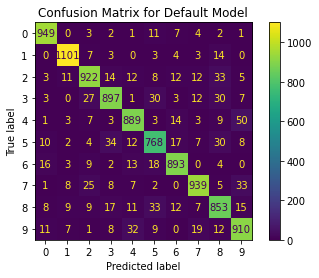

Test accuracy for the default model: 0.9121


In [11]:
# Inference with trained model
predictions = default_model.inference(X_test)
true_classes = np.argmax(y_test, axis = 1)
confusion_matrix = metrics.confusion_matrix(true_classes, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = np.arange(0,10,1))
test_accuracy = accuracy(y_test, predictions)
cm_display.plot()
plt.title("Confusion Matrix for Default Model")
plt.show()
print(f"Test accuracy for the default model: {test_accuracy}")

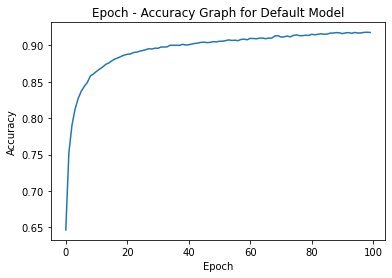

In [12]:
# Epoch - Accuracy Graph for the default model
plt.plot(np.arange(len(accuracy_values_default)), accuracy_values_default)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch - Accuracy Graph for Default Model")
plt.show()

## Question 2.2 Other Models

In [43]:
# Lists of Hyperparameter Initializations for the experimental models
batch_sizes = [1, 64, 50000]
lrs = [0.1, 1e-3, 1e-4, 1e-5]
lambdas = [1e-2, 1e-4, 1e-9]
weights_list = [np.zeros((784, 10)), np.random.uniform( -0.1, 0.1, (784, 10)), np.random.normal(0, 1, (784, 10))]

### Experimenting with batch size, all the other parameters are default
* Regularization Coefficient = 1e-4
* Learning Rate = 5e-4
* Weight initialization: Normal Distribution

In [44]:
accuracy_values_list = []
for b_size in batch_sizes:
    model = LogisticRegression(n_features, n_classes, lambda_, 2)
    accuracy_values_list.append(model.train(X_train, y_train, batch_size = b_size))

100%|███████████████████████████████████████████| 100/100 [00:57<00:00,  1.75it/s]


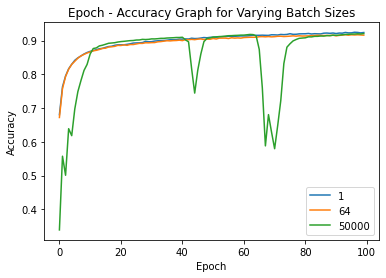

In [46]:
for i in range(len(batch_sizes)):
    plt.plot(np.arange(len(accuracy_values_list[i])), accuracy_values_list[i])
plt.legend(batch_sizes)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch - Accuracy Graph for Varying Batch Sizes")
plt.show()

### Experimenting with weight initialization method, all the other parameters are default
* Regularization Coefficient = 1e-4
* Learning Rate = 5e-4
* Batch Size = 200

In [17]:
accuracy_values_list = []
weight_methods = {0 : "Zero Initialization", 1 : "Uniform Distribution", 2 : "Normal Distribution"}
for w in range(len(weight_methods)):
    model = LogisticRegression(n_features, n_classes, lambda_, w)
    accuracy_values_list.append(model.train(X_train, y_train))

100%|███████████████████████████████████████████| 100/100 [00:41<00:00,  2.43it/s]


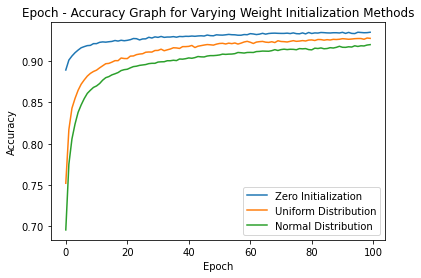

In [18]:
for i in range(len(weight_methods)):
    plt.plot(np.arange(len(accuracy_values_list[i])), accuracy_values_list[i])
plt.legend(weight_methods.values())
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch - Accuracy Graph for Varying Weight Initialization Methods")
plt.show()

### Experimenting with regularization coefficient, all the other parameters are default
* Learning Rate = 5e-4
* Batch Size = 200
* Weight Initialization: Normal Distribution

In [20]:
accuracy_values_list = []
for i, lmbd in enumerate(lambdas):
    model = LogisticRegression(n_features, n_classes, lmbd, 2)
    accuracy_values_list.append(model.train(X_train, y_train, batch_size = 200, epochs = 100))

100%|███████████████████████████████████████████| 100/100 [00:42<00:00,  2.35it/s]


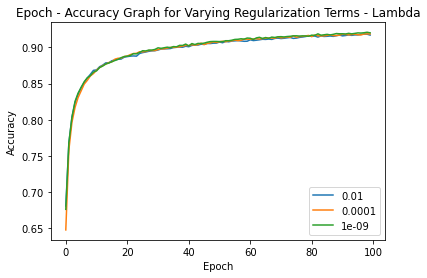

In [21]:
for i in range(len(lambdas)):
    plt.plot(np.arange(len(accuracy_values_list[i])), accuracy_values_list[i])
plt.legend(lambdas)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch - Accuracy Graph for Varying Regularization Terms - Lambda")
plt.show()

### Experimenting with  learning rate, all the other parameters are default
* Regularization Coefficient: 1e-4
* Batch Size = 200
* Weight Initialization: Normal Distribution

In [25]:
accuracy_values_list = []
for i, lr_ in enumerate(lrs):
    model = LogisticRegression(n_features, n_classes, lambda_, 2)
    accuracy_values_list.append(model.train(X_train, y_train, lr = lr_, batch_size = 200, epochs = 100))

100%|███████████████████████████████████████████| 100/100 [00:39<00:00,  2.56it/s]


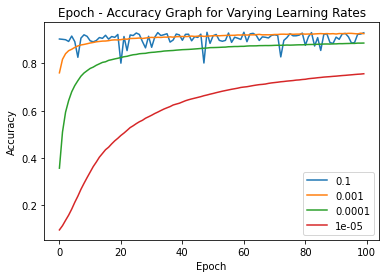

In [24]:
for i in range(len(lrs)):
    plt.plot(np.arange(len(accuracy_values_list[i])), accuracy_values_list[i])
plt.legend(lrs)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch - Accuracy Graph for Varying Learning Rates")
plt.show()

## Question 2.3 Best Model

Based on the above experiments, we create the best model with the following parameters: 

* Batch Size: 64, similar performance to Batch Size = 1, but works way faster. 

* Weight Initialization Method: Zero Initialization  

* Learning Rate: 0.001 

* Regularization Coefficient: 0.0001, almost the same performance as others. 

In [26]:
best_model = LogisticRegression(n_features, n_classes, lambda_ = 1e-4, weight_method = 0)
best_model.train(X_train, y_train, lr = 1e-3, batch_size = 64, epochs = 100)
predictions = best_model.inference(X_test)
test_accuracy = accuracy(y_test, predictions)

100%|███████████████████████████████████████████| 100/100 [00:50<00:00,  1.98it/s]


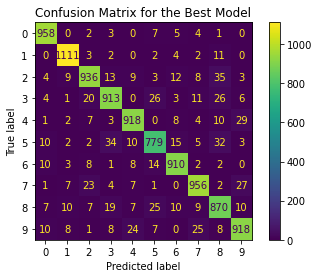

In [27]:
confusion_matrix = metrics.confusion_matrix(np.argmax(y_test, axis = 1), predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = np.arange(0,10,1))
cm_display.plot()
plt.title("Confusion Matrix for the Best Model")
plt.show()

In [28]:
print(f"Test Accuracy for the best model: {test_accuracy}")

Test Accuracy for the best model: 0.9269


## Question 2.4 Visualizing the Weights


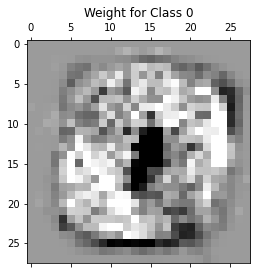

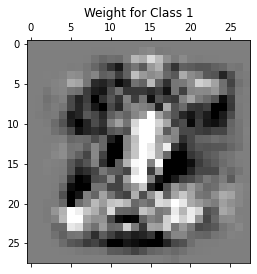

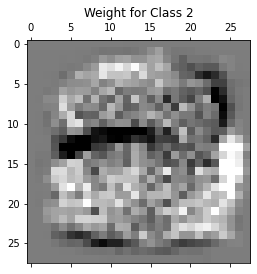

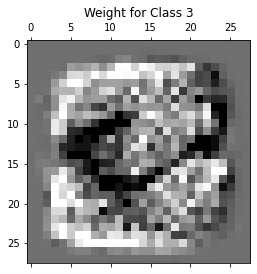

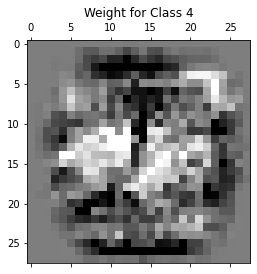

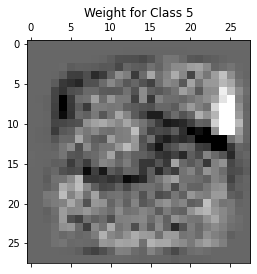

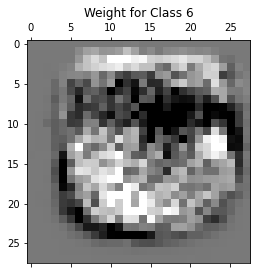

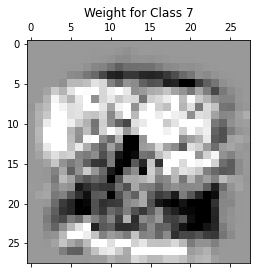

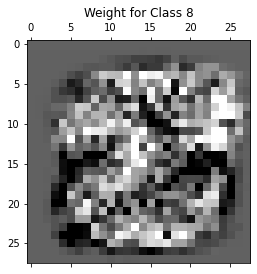

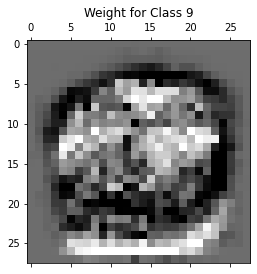

In [29]:
# Code to visualize weights
for i in range(best_model.weight.shape[1]):
    img = best_model.weight[:, i].reshape(28,28)
    plt.matshow(img, cmap=plt.cm.gray, vmin = 0.5 * img.min(), vmax = 0.5 * img.max())
    plt.title(f'Weight for Class {i}')
    plt.show()

In [30]:
# Function to compute the metrics recall, precision, and f_1 and f_2 scores
def compute_metrics(y_test, y_pred):
    conf_mat = metrics.confusion_matrix(np.argmax(y_test, axis = 1), predictions)
    
    # for each class, we will save these metrics
    recall = np.zeros(10)
    precision = np.zeros(10)
    f_1 = np.zeros(10) 
    f_2 = np.zeros(10)
    
    for i in range(10):
        tp = conf_mat[i, i]
        fp = np.sum(conf_mat[:, i]) - tp
        fn = np.sum(conf_mat[i, :]) - tp
        tn = np.sum(conf_mat) - tp - fp - fn
        
        if tp + fn == 0: # <- to avoid division by zero
            recall[i] = 0
        else:
            recall[i] = tp / (tp+fn)
        
        if tp + fp == 0: # <- to avoid division by zero
            precision[i] = 0
        else:
            precision[i] = tp / (tp+fp)
                
        if precision[i]+recall[i] != 0:
            f_1[i] = 2 * precision[i] * recall[i] / ( precision[i] + recall[i])
        else: # <- to avoid division by zero
            f_1[i] = 0
        
        if 4 * precision[i] + recall[i] != 0:
            f_2[i] = 5 * precision[i] * recall[i] / (4 * precision[i] + recall[i])
        else: # <- to avoid division by zero
            f_2[i] = 0
    return recall, precision, f_1, f_2

recall, precision, f_1, f_2 = compute_metrics(y_test, predictions)

In [31]:
print("RECALL")
for i in range(10):
    print(f"\tClass {i}: {recall[i]}")
print()

print("PRECISION")
for i in range(10):
    print(f"\tClass {i}: {precision[i]}")
print()
print("F_1")
for i in range(10):
    print(f"\tClass {i}: {f_1[i]}")
print()
print("F_2")
for i in range(10):
    print(f"\tClass {i}: {f_2[i]}")
print()


RECALL
	Class 0: 0.9775510204081632
	Class 1: 0.9788546255506608
	Class 2: 0.9069767441860465
	Class 3: 0.903960396039604
	Class 4: 0.9348268839103869
	Class 5: 0.8733183856502242
	Class 6: 0.9498956158663883
	Class 7: 0.9299610894941635
	Class 8: 0.893223819301848
	Class 9: 0.9098116947472745

PRECISION
	Class 0: 0.9532338308457712
	Class 1: 0.9635732870771899
	Class 2: 0.9276511397423192
	Class 3: 0.913
	Class 4: 0.9338758901322483
	Class 5: 0.9016203703703703
	Class 6: 0.9410548086866598
	Class 7: 0.9317738791423001
	Class 8: 0.872617853560682
	Class 9: 0.9216867469879518

F_1
	Class 0: 0.9652392947103274
	Class 1: 0.9711538461538461
	Class 2: 0.9171974522292994
	Class 3: 0.9084577114427861
	Class 4: 0.9343511450381679
	Class 5: 0.8872437357630979
	Class 6: 0.9454545454545455
	Class 7: 0.9308666017526777
	Class 8: 0.882800608828006
	Class 9: 0.91571072319202

F_2
	Class 0: 0.9725888324873097
	Class 1: 0.9757597049007555
	Class 2: 0.9110375705664784
	Class 3: 0.9057539682539681
	Clas